In [4]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import math
import numpy as np
import os
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from scipy.stats import norm
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm

In [5]:
class GittinsIndex:
    def __init__(self, Sigma, n, N = 20, gamma = 0.9, xi = 3, delta = 0.02):
        self.Sigma = Sigma
        self.n = n
        self.mu = self.Sigma / self.n
        self.N = N
        self.gamma = gamma
        self.xi = xi
        self.delta = delta
    
    def valueFunction(self, Lambda = 0):
        mid = math.ceil(self.xi * np.sqrt(1 / self.n) / self.delta)
        number_mu = mid * 2 + 1
        mu_plus = np.linspace(self.mu - mid * self.delta, self.mu + mid * self.delta, num = number_mu) 
        
        lo = mu_plus - self.delta / 2
        hi = mu_plus + self.delta / 2

        value_vec_prev = np.zeros(number_mu)
        value_vec_curr = np.zeros(number_mu)
        
        for i in range(number_mu):
            value_vec_prev[i] = max(mu_plus[i] - Lambda, 0) / (1 - self.gamma) # without discount

        for t in reversed(range(1, self.N)):  # from N - 1 to 1
            t_n = t + self.n
            s = np.sqrt(1 / t_n + 1)
            y_hi, y_lo = hi * (t_n + 1), lo * (t_n + 1)
    
            for j in reversed(range(number_mu)):
                yhi = y_hi - mu_plus[j] * t_n
                ylo = y_lo - mu_plus[j] * t_n
                p = norm.cdf(yhi, loc = mu_plus[j], scale = s) - norm.cdf(ylo, loc = mu_plus[j], scale = s)

                risk_reward = mu_plus[j] + self.gamma * (norm.cdf(ylo[0], loc = mu_plus[j], scale = s) * value_vec_prev[0] +
                              (1 - norm.cdf(yhi[-1], loc = mu_plus[j], scale = s)) * value_vec_prev[-1] +
                              np.dot(p, value_vec_prev))
                
                if t == 0 and j == mid:
                    return risk_reward - Lambda
                
                if risk_reward > Lambda: 
                    value_vec_curr[j] = risk_reward - Lambda  # discount factor already computed for every iter
                else:
                    value_vec_curr[:j + 1] = 0
                    break
                
            value_vec_prev = value_vec_curr.copy()

            
        # time 0
        s = np.sqrt(1 / self.n + 1)

        
        
        y_hi, y_lo = hi * (self.n + 1), lo * (self.n + 1)
        yhi, ylo = y_hi - mu_plus[mid] * self.n, y_lo - mu_plus[mid] * self.n
        

        p = norm.cdf(yhi, loc = mu_plus[mid], scale = s) - norm.cdf(ylo, loc = mu_plus[mid], scale = s)
        
        risk_reward = (mu_plus[mid] + self.gamma * (norm.cdf(ylo[0], loc = mu_plus[mid], scale = s) * value_vec_prev[0] +
                      (1 - norm.cdf(yhi[-1], loc = mu_plus[mid], scale = s)) * value_vec_prev[-1] +
                      np.dot(p, value_vec_prev)))

        return risk_reward - Lambda  # risk - safe reward without taking max(V, 0)

In [6]:
sigma_range = np.linspace(-3, 3, num = 301)
v1 = []
for sig in tqdm(sigma_range):
    v1.append(GittinsIndex(Sigma = sig, n = 1, gamma = 0.9, xi = 3, delta = 0.02).valueFunction(Lambda = 0))

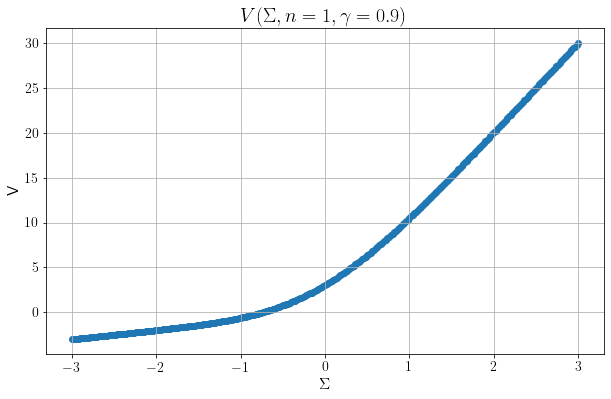

In [6]:
fig = plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.scatter(np.linspace(-3, 3, num = 301), v1)
plt.xlabel(r"$\Sigma$", size=16)
plt.ylabel("V", size=16)
plt.title(r"$V(\Sigma, n = 1, \gamma = 0.9)$", fontsize = 20)
plt.grid()
plt.show()

In [7]:
fsolve(interp1d(np.linspace(-3, 3, num = 301), v1), 0, xtol = 1e-5)

array([-0.74582978])

# translation invariance property

In [10]:
sigma_range = np.linspace(-3, 3, num = 61)
value_function_lambda0 = []
for sig in tqdm(sigma_range):
    value_function_lambda0.append(GittinsIndex(Sigma = sig, n = 1, gamma = 0.9, xi = 3, delta = 0.02).valueFunction())

In [14]:
sigma_range = np.linspace(-2, 4, num = 61)
value_function_lambda1 = []
for sig in tqdm(sigma_range):
    value_function_lambda1.append(GittinsIndex(Sigma = sig, n = 1, gamma = 0.9, xi = 3, delta = 0.02).valueFunction(Lambda = 1))

In [15]:
sigma_range = np.linspace(-2.5, 3.5, num = 61)
value_function_lambda05 = []
for sig in tqdm(sigma_range):
    value_function_lambda05.append(GittinsIndex(Sigma = sig, n = 1, gamma = 0.9, xi = 3, delta = 0.02).valueFunction(Lambda = 0.5))

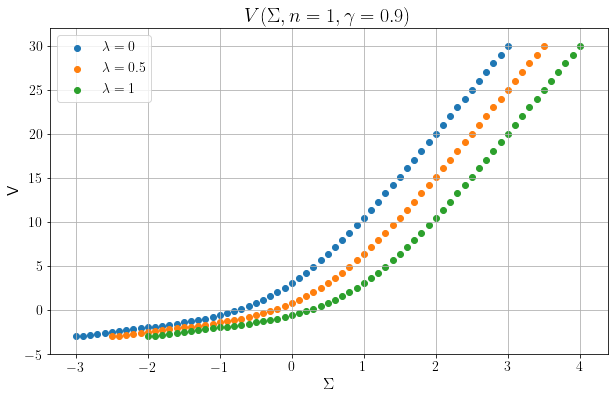

In [16]:
fig = plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.scatter(np.linspace(-3, 3, num = 61), value_function_lambda0, label = r"$\lambda = 0$")
plt.scatter(np.linspace(-2.5, 3.5, num = 61), value_function_lambda05, label = r"$\lambda = 0.5$")
plt.scatter(np.linspace(-2, 4, num = 61), value_function_lambda1, label = r"$\lambda = 1$")
plt.xlabel(r"$\Sigma$", fontsize = 16)
plt.ylabel("V", fontsize = 16)
plt.title(r"$V(\Sigma, n = 1, \gamma = 0.9)$", fontsize = 20)
plt.grid()
plt.legend()
plt.show()

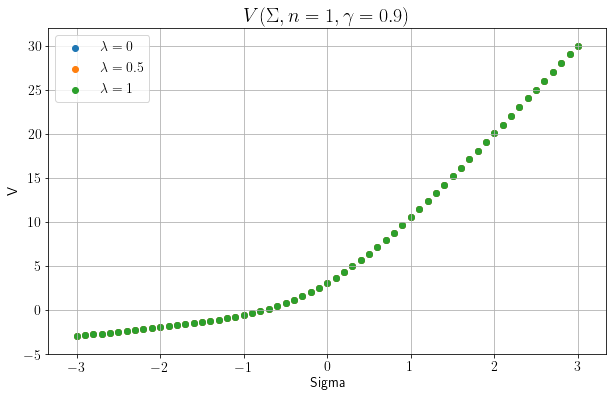

In [17]:
plt.figure(figsize=(10,6))
plt.rc('font', size=14)
plt.scatter(np.linspace(-3, 3, num = 61), value_function_lambda0, label = r"$\lambda = 0$")
plt.scatter(np.linspace(-3, 3, num = 61), value_function_lambda05, label = r"$\lambda = 0.5$")
plt.scatter(np.linspace(-3, 3, num = 61), value_function_lambda1, label = r"$\lambda = 1$")
plt.xlabel("Sigma")
plt.ylabel("V")
plt.title(r"$V(\Sigma, n = 1, \gamma = 0.9)$", fontsize = 20)
plt.grid()
plt.legend()
plt.show()